### Basic imports

In [0]:
import os, sys, glob
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Helper functions

In [2]:
import time
from keras.callbacks import Callback
import numpy as np
import pandas as pd
import os

def progress_bar(current_value, max_value):
    progress = ((current_value+1)/max_value)*100
    if progress>98: progress=100
    print('\r[{0}{1}] {2:.1f}%'.format('#'*int(progress/2), ' '*(50-int(progress/2)), progress), end='')


def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)
    

class LossHistory(Callback):
    def __init__(self, number_of_epochs, logging_parameter='acc'):
        self.number_of_epochs = number_of_epochs
        self.current_epoch = 0
    def on_train_begin(self, logs={}):
        self.initial_time = time.time()
    def on_batch_end(self, batch, logs={}):
        if logs['batch']==0:
            NUMBER_OF_DIESIS = 20
            self.current_epoch += 1
            progress = self.current_epoch/self.number_of_epochs
            diesis = np.round(progress*NUMBER_OF_DIESIS).astype('int')
            eta = (time.time()-self.initial_time) * (self.number_of_epochs/self.current_epoch -1)
            remaining_time = time.strftime("%H hours, %M min, %S sec", time.gmtime(eta))
            print('\r[{}{}] {}: {:.3f} eta: {}'.format(
                '#'*diesis, '-'*(NUMBER_OF_DIESIS-diesis), logging_parameter, logs[logging_parameter], remaining_time), end='')

def add_grid_and_save(grid):
    # save data in temporary dataframe if cross validation is not over
    if len(grid['fit_outs'][1]) < grid['skf_n_splits'][1]:
        temp_grid_file_path = '{}/grids/grid_tmp.pkl'.format(grid['root_path'][1])
        grid_df = pd.DataFrame()
        grid_df = grid_df.append({key:grid[key][1] for key in grid.keys()}, ignore_index=True)
        grid_df.to_pickle(temp_grid_file_path)

    else:
        grid_file_path = '{}/grids/grid_{}.pkl'.format(grid['root_path'][1], grid['version'][1])
        if os.path.isfile(grid_file_path):
            grid_df = pd.read_pickle(grid_file_path)
        else:
            grid_df = pd.DataFrame()

        grid_df = grid_df.append({key:grid[key][1] for key in grid.keys()}, ignore_index=True)
        grid_df.to_pickle(grid_file_path)
        
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
def quadratic_kappa(actuals, preds, N=5):
    """This function calculates the Quadratic Kappa Metric used for Evaluation in the PetFinder competition
    at Kaggle. It returns the Quadratic Weighted Kappa metric score between the actual and the predicted values 
    of adoption rating."""
    w = np.zeros((N,N))
    O = confusion_matrix(actuals, preds)
    for i in range(len(w)): 
        for j in range(len(w)):
            w[i][j] = float(((i-j)**2)/(N-1)**2)
    
    act_hist=np.zeros([N])
    for item in actuals: 
        act_hist[item]+=1
    
    pred_hist=np.zeros([N])
    for item in preds: 
        pred_hist[item]+=1
                         
    E = np.outer(act_hist, pred_hist);
    E = E/E.sum();
    O = O/O.sum();
    
    num=0
    den=0
    for i in range(len(w)):
        for j in range(len(w)):
            num+=w[i][j]*O[i][j]
            den+=w[i][j]*E[i][j]
    return (1 - (num/den))

Using TensorFlow backend.


### Load and preprocess data

In [0]:
from sklearn.model_selection import train_test_split

def load_data(grid):
#     root_path = grid['rooth_path'][1]
#     data_filename = f'{root_path}/data/data_xception.h5'
#     with h5py.File(data_filename, "r") as out:
#         X_train = out['X_train']
#         y_train = out['y_train']
#         X_test = out['X_test']
#         y_test = out['y_test']
    
    return X_train, X_test, y_train, y_test


def pre_process_data(X, y, grid):
    ### TODO
    return X_processed, y_processed

### Create model and training parameters

In [0]:
from keras import models
from keras.applications import Xception
from keras import layers
    
def create_model(grid):
   
    conv_base = Xception(weights = 'imagenet',
                        include_top = False,
                        input_shape = (299, 299, 3))

    conv_base.trainable=False
    


    model = models.Sequential()
    model.add(conv_base)
#     model.add(layers.Flatten())
#     model.add(layers.Dense(50, activation='relu'))

    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Dropout(0.1))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))

    return model


from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam

def train_model(X, y, model, grid):
    skf = StratifiedKFold(n_splits=grid['skf_n_splits'][1], shuffle=True)
    train_index, dev_index = list(skf.split(X, y))[len(grid['fit_outs'][1])]
    
    X_train, X_dev = X[train_index], X[dev_index]
    y_train, y_dev = y[train_index], y[dev_index]

    progress_bar = LossHistory(grid['epochs'][1], logging_parameter=grid['training_metric'][1])
    chk = ModelCheckpoint(grid['best_model_paths'][1][-1], monitor=grid['best_model_metric'][1],
                          save_best_only=True, mode='max', verbose=0)
    
    optimizer = keras.optimizers.Adam(lr=grid['learning_rate'][1])
    model.compile(loss=grid['loss'][1], optimizer=optimizer, metrics=[grid['training_metric'][1]])
    fit_out = model.fit(X_train, y_train, epochs=grid['epochs'][1], batch_size=grid['batch_size'][1],
                        callbacks=[progress_bar], validation_data=(X_dev, y_dev), verbose=0)

    fit_out.model = None
    fit_out.epoch = None
    fit_out.validation_data = None
    grid['fit_outs'][1].append(fit_out)
    return grid

### Data generators

In [0]:
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

def create_data_generator(X, y, batch_size):    
    number_of_samples = X.shape[0]
    print(f'Creating generator from {number_of_samples} samples')
    
    index = 0
    IMG_SIZE = 299
    NUM_CLASSES = 5
    
    while True:
        data_X = np.zeros([batch_size, IMG_SIZE, IMG_SIZE, 3])
        data_y = np.zeros([batch_size, NUM_CLASSES])
        
        for i in range(batch_size):
            data_X[i, ...] = preprocess_input(X[index % number_of_samples,...])
            data_y[i, :] = y[index % number_of_samples, :]
            index = index + 1
        yield data_X, data_y
        

        
def create_data_random_generator(X, y, batch_size):
    
    image_randomiser = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.02,
        height_shift_range=0.02,
        zoom_range=0.02,
        fill_mode='nearest',
        horizontal_flip=True)
    
    
    number_of_samples = X.shape[0]
    print(f'Creating generator from {number_of_samples} samples')


    index = 0
    IMG_SIZE = 299
    NUM_CLASSES = 5
    
    while True:
        data_X = np.zeros([batch_size, IMG_SIZE, IMG_SIZE, 3])
        data_y = np.zeros([batch_size, NUM_CLASSES])
        
        transformation = image_randomiser.get_random_transform(img_shape=(IMG_SIZE,IMG_SIZE,3))
        
        for i in range(batch_size):
            data_X[i, ...] = preprocess_input(image_randomiser.apply_transform(
                        X[index % number_of_samples,...], transformation))
            data_y[i, :] = y[index % number_of_samples, :]
            index = index + 1
            
        yield data_X, data_y
        
        
# import h5py

# with h5py.File(f'{ROOT_PATH}/data/data.h5', 'r') as f:    
#     test_generator = create_data_generator(f['X_test'][()], f['y_test'][()], 32)
    
# a, b = next(test_generator)

### Run training

In [0]:
import time
import numpy as np

def run_training(X, y, grid, verbose=True):
    initial_time = time.time()
    
    for index_split in range(grid['skf_n_splits'][1]): # looping on uncompleted CV trainings
        print(f"\nCV validation {index_split+1} of {grid['skf_n_splits'][1]}")

        model = create_model(grid)
        best_model_path = '{}/models/{}/best_model_{}_{}.pkl'.format(grid['root_path'][1], grid['version'][1], grid['test_index'][1], index_split)
        grid['best_model_paths'][1].append(best_model_path)
              
        grid = train_model(X, y, model, grid)
        grid['best_model_results'][1].append(np.max(grid['fit_outs'][1][-1].history[grid['best_model_metric'][1]]))
        add_grid_and_save(grid)

    total_time = time.strftime("%H hours, %M min, %S sec", time.gmtime((time.time() - initial_time)))
    print('  --  Model trained in {}'.format(total_time))
    return grid

### Init

In [7]:
VERSION = '01'

try:
    import google.colab
    from google.colab import drive

    drive.mount('/content/gdrive', force_remount=True)
    ROOT_PATH = 'gdrive/My Drive/Colab Notebooks/APTOS' # project path in drive
    print('Working on google colab')
except:
    ROOT_PATH = '..'
    print('Working locally')

# where models and grids are saved
directories = [f'{ROOT_PATH}/models/{VERSION}', f'{ROOT_PATH}/grids/']
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Working on google colab


### Grid

In [0]:
def create_grid(params={}):
    
    grid_file_path = '{}/grids/grid_{}.pkl'.format(ROOT_PATH, VERSION)
    
    if os.path.isfile(grid_file_path):
        grid_df = pd.read_pickle(grid_file_path)
        test_index = grid_df['test_index'].max() + 1
    else:
        test_index = 0

    current_grid = {
        'version'                : ['str'     , VERSION],
        'params'                 : ['O'       , params],
        'test_index'             : [np.int    , test_index],
        'root_path'              : ['str'     , ROOT_PATH],
        
        # Metrics
        'best_model_metric'      : ['str'     , 'val_acc'],
        'training_metric'        : ['str'     , 'accuracy'],
        'loss'                   : ['str'     , 'categorical_crossentropy'],
        
        # Training parameters
        'epochs'                 : [np.int    , 250],
        'batch_size'             : [np.int    , 32],
        'skf_n_splits'           : [np.int    , 5],
        
        # Outputs
        'best_model_paths'       : ['O'       , []],
        'best_model_results'     : ['O'       , []],
        'fit_outs'               : ['O'       , []]}

    for key, value in params.items():
        current_grid[key][1] = value
    return current_grid

### Load data into memory

In [15]:
import h5py
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32
with h5py.File(f'{ROOT_PATH}/data/data_xception.h5', 'r') as f:
    X_train, y_train = f['X_train'][()], f['y_train'][()]
    X_dev, y_dev = f['X_dev'][()], f['y_dev'][()]
    
    new_train_len = int(X_train.shape[0] - (X_train.shape[0] % BATCH_SIZE))
    train_generator = create_data_random_generator(X_train[:new_train_len,:,:,:], y_train[:new_train_len,:], BATCH_SIZE)
    
    new_dev_len = int(X_dev.shape[0] - (X_dev.shape[0] % BATCH_SIZE))
    dev_generator = create_data_generator(X_dev[:new_dev_len,:,:,:], y_dev[:new_dev_len,:], BATCH_SIZE)

    print(f'Build train generator with {new_train_len} elements: {int(new_train_len/BATCH_SIZE)} batches of size {BATCH_SIZE}')
    print(f'Build dev generator with {new_dev_len} elements: {int(new_dev_len/BATCH_SIZE)} batches of size {BATCH_SIZE}')    

Build train generator with 2560 elements: 80 batches of size 32
Build dev generator with 544 elements: 17 batches of size 32


### Run model

In [16]:
from keras import optimizers


grid = create_grid()
model = create_model(grid)
outs = []

W0725 07:19:32.664783 139946748364672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 07:19:33.026612 139946748364672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 07:19:33.035296 139946748364672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 07:19:33.079101 139946748364672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0725 07:19:33.080375 1399467483

83689472/83683744 [==============================] - 3s 0us/step


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                102450    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
Total params: 20,964,185
Trainable params: 102,705
Non-trainable params: 20,861,480
_________________________________________________________________


In [20]:
class_weight = {0:0.793651+5,
                2:1.426534+5,
                1:3.861004+5,
                4:4.830918+5,
                3:7.352941+5}
model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(lr=5e-4),
             metrics=['accuracy'])

out = model.fit_generator(train_generator,
                         steps_per_epoch = 80,
                         epochs=30,
                         validation_data = dev_generator,
                         validation_steps = 17,
                         verbose=1,
                         class_weight=class_weight)

outs.append(out)

Epoch 1/30
80/80 [==============================] - 80s 1s/step - loss: 3.0218 - acc: 0.8555 - val_loss: 1.4913 - val_acc: 0.6507
Epoch 2/30
80/80 [==============================] - 72s 899ms/step - loss: 2.9312 - acc: 0.8625 - val_loss: 1.4790 - val_acc: 0.6489
Epoch 3/30
80/80 [==============================] - 73s 908ms/step - loss: 2.9969 - acc: 0.8570 - val_loss: 1.5128 - val_acc: 0.6507
Epoch 4/30
80/80 [==============================] - 72s 903ms/step - loss: 2.9700 - acc: 0.8555 - val_loss: 1.4609 - val_acc: 0.6507
Epoch 5/30
80/80 [==============================] - 72s 905ms/step - loss: 2.9209 - acc: 0.8633 - val_loss: 1.5364 - val_acc: 0.6434
Epoch 6/30
80/80 [==============================] - 72s 898ms/step - loss: 2.9295 - acc: 0.8625 - val_loss: 1.5057 - val_acc: 0.6581
Epoch 7/30
80/80 [==============================] - 72s 899ms/step - loss: 2.8987 - acc: 0.8648 - val_loss: 1.4585 - val_acc: 0.6544
Epoch 8/30
80/80 [==============================] - 72s 903ms/step - los

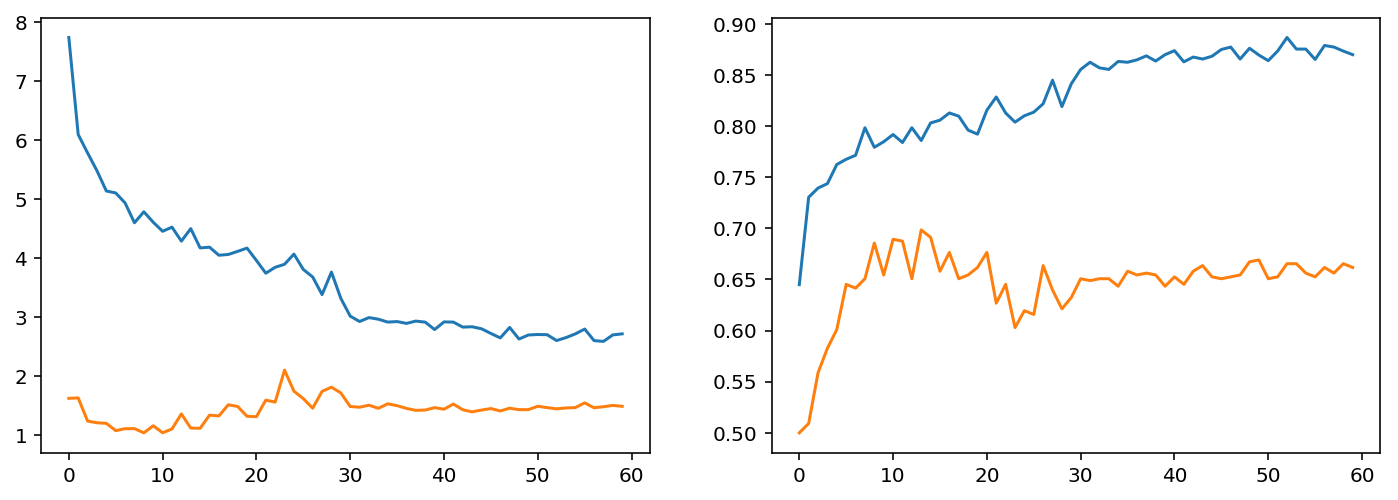

In [21]:

losses, val_losses = [], []
acc, val_acc = [], []

for out in outs:
    for h in out.history['loss']:
        losses.append(h)
    for h in out.history['val_loss']:
        val_losses.append(h)
        
    for h in out.history['acc']:
        acc.append(h)
    for h in out.history['val_acc']:
        val_acc.append(h)


        

        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(losses)
ax1.plot(val_losses)

ax2.plot(acc)
ax2.plot(val_acc)
# plt.yscale('log')
# plt.ylim(0.006,0.02)



In [0]:
# with h5py.File(f'{ROOT_PATH}/data/data_xception.h5', 'r') as f:
#     X_test, y_test = f['X_test'][()], f['y_test'][()]

In [22]:
CUT = 100
y_model_output = model.predict(X_dev[:CUT, ...])

y_prediction = np.argmax(y_model_output, axis=1)
y_true = np.argmax(y_dev[:CUT, ...], axis=1)

quadratic_kappa(y_true, y_prediction)

-0.005329457364341206

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(y_prediction, y_true)

0.46

In [24]:
quadratic_kappa(y_true, y_prediction)

-0.005329457364341206

In [0]:
# plt.hist(y_true.mean(1))
y_model_output.mean(0)

array([7.2921473e-01, 3.4812382e-09, 2.4721348e-01, 2.3571838e-02,
       2.3287687e-13], dtype=float32)

In [0]:
y_model_output.mean(0)

array([7.2921473e-01, 3.4812382e-09, 2.4721348e-01, 2.3571838e-02,
       2.3287687e-13], dtype=float32)

In [25]:
np.argmax(y_model_output, axis=1)

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
y_dev.shape

(549, 5)

### Old stuff

In [0]:
def test_params(next_point_to_probe):
    with open (f'{root_path}log.txt', 'a') as f:
        f.write(f'{time.ctime()}  -  starting {next_point_to_probe}\n')
    print(f'Testing {next_point_to_probe}')

    
    grid = create_grid(next_point_to_probe)
    
    X_train, X_test, y_train, y_test = load_data(grid)
    X_train, y_train = pre_process_data(X_train, y_train, grid)
    X_test, y_test = pre_process_data(X_test, y_test, grid)
    grid = run_training(X_train, y_train, grid, verbose=True)
    
    val_acc_history = [fit_out.history['val_acc'] for fit_out in grid['fit_outs'][1]]
    val_accuracy_estimator = np.mean(val_acc_history, 0)[130:180].mean()
    with open (f'{root_path}log.txt', 'a') as f:
        f.write(f'{time.ctime()}  -  finished {next_point_to_probe}\n')
    
    return val_accuracy_estimator

In [0]:
# %%time


ps = Parameter_space(bounds={
    'l1_regularizer' : (-3.8, -3.7, 'log'),
    'epochs' : (400, 401, 'int')
})



# ps.bayesopt(test_params, kappa=0.25)


# # ## BAYESIAN SEARCH
# grid_file_path = '{}/model_data/grid_{}.pkl'.format(root_path, VERSION)
# if os.path.isfile(grid_file_path):
#     grid_df = pd.read_pickle(grid_file_path)


#     for fo, param in zip(grid_df.fit_outs, grid_df.params):
#         somma = [x.history['val_acc'] for x in fo]    
#         s = np.mean(somma, 0)[130:180].mean()
#         ps.register_point(param, s)

for _ in range(50):
    next_point_to_probe = ps.get_random_next(time_seed=True)
    target = test_params(next_point_to_probe)
# #     ps.register_point(point=next_point_to_probe, target=target)

In [0]:
aa = np.random.random(14)

In [0]:
aa.sort()

In [0]:
aa


array([0.00419477, 0.01583127, 0.33773212, 0.35494611, 0.3985656 ,
       0.46138782, 0.5295456 , 0.56211477, 0.5991052 , 0.6457113 ,
       0.66379054, 0.67912987, 0.76138679, 0.98563809])